In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

# Create a phonebook

A phonebook maps clusters to partitions under the following constraints.

1. All clusters in the same bucket MUST go in the same partition.
2. A partition CANNOT contain clusters totalling more than N records.
3. Clusters that are similar to each other SHOULD go in the same partition.

## Aproach

1. Choose a maximum number of partitions and a maximum number of records per partition.
2. Compute the top N most-similar clusters to each cluster.
3. Start by putting the clusters for each bucket in their own partition.
4. Some buckets because of their size will span multiple partitions. Split those buckets up-front.
5. While there are more than the maximum number of partitions, merge partitions containing the most-similar (to least-similar) clusters so long as the combined partition doesn't exceed the maximum partition size.
6. If you end up with too many partitions, or many partitions that have significantly fewer number of records than the maximum, consider repeating the steps with a lower maximum number of records per partition.

In [2]:
from collections import defaultdict
import json
import re

import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm

from src.data.utils import read_csv
from src.models.utils import top_similar_names

In [13]:
# configure
given_surname = "surname"
phonebook_type = 'hr'  # 'tree'

pref_prefix = 'hr' if phonebook_type == 'hr' else 'tree-preferred'
n_partitions = 720
max_partition_size = 15_800_000 if phonebook_type == 'hr' else 1_250_000
min_threshold = 0.6

linkage = "average"
similarity_threshold = 0.25
scorer = "ce"
cluster_freq_normalizer = "none"
clusters_path = f"../data/processed/clusters_{given_surname}-{scorer}-{linkage}-{similarity_threshold}-{cluster_freq_normalizer}-augmented.json"
super_clusters_path = f"../data/processed/super_clusters_{given_surname}-{scorer}-{linkage}-{similarity_threshold}-{cluster_freq_normalizer}.json"
pref_path = f"../data/processed/{pref_prefix}-{given_surname}-aggr.csv.gz"

phonebook_path = f"../data/processed/{phonebook_type}-phonebook.json"

### Load data

In [15]:
# dict of name -> freq
pref_df = read_csv(pref_path)
name_freq = {name: freq for name, freq in zip(pref_df['name'], pref_df['frequency']) \
                if re.fullmatch(r'[a-z]+', name)}
pref_df = None

In [16]:
print(len(name_freq))
print(sum(list(name_freq.values())))

145979741
12978634062


In [6]:
# load clusters and super-clusters
name_cluster = {}       # name -> cluster position
cluster_centroids = []  # centroid for each cluster
cluster_labels = []     # label for each cluster
cluster_indexes = {}    # cluster label -> index
cluster_sizes = []      # number of records for each cluster

with open(clusters_path, 'r') as f:
    clusters = json.load(f)  # cluster label -> names, centroid

with open(super_clusters_path, 'r') as f:
    super_clusters = json.load(f)  # super_cluster label -> cluster labels

for label, cluster in clusters.items():
    n_records = 0
    for name in cluster['names']:
        name_cluster[name] = len(cluster_labels)
        n_records += name_freq.get(name, 0)
    cluster_indexes[label] = len(cluster_labels)
    cluster_labels.append(label)
    cluster_sizes.append(n_records)
    cluster_centroids.append(np.array(cluster['centroid']))
cluster_labels = np.array(cluster_labels)

In [7]:
print('number of names', len(name_cluster))
print('number of clusters', len(cluster_labels))
print('number of super-clusters', len(super_clusters))

number of names 525447
number of clusters 79888
number of super-clusters 12091


In [8]:
print('size of all clusters', sum(cluster_sizes))

size of all clusters 11275305233


In [9]:
print('perfect partition size', sum(cluster_sizes) / n_partitions)

perfect partition size 15660146.156944444


## Compute nearby clusters

In [10]:
cluster_similarity_scores = []  # [(ix1, ix2, similarity)]
top_n = 1000
for ix, centroid in tqdm(enumerate(cluster_centroids), mininterval=2.0):
    nearby_clusters, similarities = top_similar_names(centroid, cluster_centroids, cluster_labels,
                                                      threshold=min_threshold, top_n=top_n)
    for nearby_cluster, similarity in zip(nearby_clusters, similarities):
        nearby_ix = cluster_indexes[nearby_cluster]
        if ix >= nearby_ix:
            continue
        cluster_similarity_scores.append((ix, nearby_ix, similarity))

0it [00:00, ?it/s]

In [11]:
cluster_similarity_scores = sorted(cluster_similarity_scores, key=lambda x: x[2], reverse=True)

In [12]:
len(cluster_similarity_scores)

1338105

## Create phonebook

In [56]:
def merge_partitions(ix1, ix2):
    global partition_ix, partition_clusters, partition_size, cluster_partitions

    # remove old partitions from cluster_partitions
    for cluster in partition_clusters[ix1]:
        cluster_partitions[cluster].remove(ix1)
    for cluster in partition_clusters[ix2]:
        cluster_partitions[cluster].remove(ix2)
    # add clusters to new partition
    partition_clusters[partition_ix] = partition_clusters[ix1] + partition_clusters[ix2]
    for cluster in partition_clusters[partition_ix]:
        cluster_partitions[cluster].append(partition_ix)    
    # calc size of new partition
    partition_size[partition_ix] = partition_size[ix1] + partition_size[ix2]
    # delete old partitions
    del partition_clusters[ix1]
    del partition_clusters[ix2]
    del partition_size[ix1]
    del partition_size[ix2]
    # update next available partition index
    partition_ix += 1

### Start by creating partitions for each cluster

In [66]:
partition_ix = 0
partition_clusters = {}                # partition -> [cluster ix]
partition_size = {}                    # partition -> size
cluster_partitions = defaultdict(list) # cluster -> [partition ix]

In [67]:
for ix in range(len(cluster_labels)):
    # calculate the number of partitions needed for the cluster
    size = cluster_sizes[ix]
    n_cluster_partitions = 1
    while size > max_partition_size:
        print(size, cluster_labels[ix])
        n_cluster_partitions += 1
        size -= max_partition_size
    # assign cluster to n_cluster_partitions
    for _ in range(n_cluster_partitions):
        partition_clusters[partition_ix] = [ix]
        cluster_partitions[ix].append(partition_ix)
        partition_size[partition_ix] = cluster_sizes[ix] / n_cluster_partitions
        partition_ix += 1

23470595 alves/alves
29317173 anderson/anderson
37807112 brown/brown
22007112 brown/brown
21475726 clark/clark
21687242 conceicao/conceicao
20918311 costa/costa
28045580 cruz/cruz
34661374 davis/davis
18861374 davis/davis
31674279 diaz/diaz
15874279 diaz/diaz
35072931 dossantos/dossantos
19272931 dossantos/dossantos
26225234 fernandez/fernandez
30830166 ferreira/ferreira
23865616 flores/flores
66326721 garcia/garcia
50526721 garcia/garcia
34726721 garcia/garcia
18926721 garcia/garcia
47170656 gomez/gomez
31370656 gomez/gomez
49991670 gonzalez/gonzalez
34191670 gonzalez/gonzalez
18391670 gonzalez/gonzalez
50257567 hernandez/hernandez
34457567 hernandez/hernandez
18657567 hernandez/hernandez
17963448 jimenez/jimenez
54733079 johnson/johnson
38933079 johnson/johnson
23133079 johnson/johnson
44305068 jones/jones
28505068 jones/jones
20392682 lima/lima
69183411 lopez/lopez
53383411 lopez/lopez
37583411 lopez/lopez
21783411 lopez/lopez
39099810 martin/martin
23299810 martin/martin
46616230 m

In [68]:
partition_ix

79982

## Review single-character names

In [69]:
total_freq = 0
for name, freq in name_freq.items():
    if len(name) > 1:
        continue
    print(name, freq)
    total_freq += freq
print(total_freq)

c 332399
j 139956
p 266863
o 406296
z 31746
s 477609
h 245474
m 1077026
e 115579
a 307938
n 390344
l 178197
x 25290
i 38836
w 732992
f 1029150
k 172686
u 246672
b 622312
d 381571
v 76770
y 60693
q 9339
g 190777
r 212747
t 110309
7879571


### Merge clusters for the same super-cluster

In [70]:
def get_smallest_partition(ixs):
    size = None
    smallest_ix = None
    for ix in ixs:
        if size is None or size > partition_size[ix]:
            size = partition_size[ix]
            smallest_ix = ix
    return ix

In [71]:
for super_cluster in super_clusters.values():
    first_cluster_label = super_cluster[0]
    for cluster_label in super_cluster[1:]:
        ix1s = cluster_partitions[cluster_indexes[first_cluster_label]]
        ix2s = cluster_partitions[cluster_indexes[cluster_label]]
        # if both clusters span multiple partions, don't try to merge
        if len(ix1s) > 1 and len(ix2s) > 1:
            continue
        # if clusters are already on same partition, don't need to merge
        if (len(ix1s) == 1 and ix1s[0] in ix2s) or (len(ix2s) == 1 and ix2s[0] in ix1s):
            continue
        # merge the smallest partition if > 1 partition
        ix1 = get_smallest_partition(ix1s) if len(ix1s) > 1 else ix1s[0]
        ix2 = get_smallest_partition(ix2s) if len(ix2s) > 1 else ix2s[0]
        if partition_size[ix1] + partition_size[ix2] <= max_partition_size:
            merge_partitions(ix1, ix2)

In [72]:
len(partition_clusters)

53649

### Merge partitions containing most-similar clusters

In [73]:
for cix1, cix2, _ in tqdm(cluster_similarity_scores, mininterval=2.0):
    if len(partition_clusters) <= n_partitions:
        break
    pix1s = cluster_partitions[cix1]
    pix2s = cluster_partitions[cix2]
    # if both clusters span multiple partions, don't try to merge
    if len(pix1s) > 1 and len(pix2s) > 1:
        continue
    # if clusters are already on same partition, don't need to merge
    if (len(pix1s) == 1 and pix1s[0] in pix2s) or (len(pix2s) == 1 and pix2s[0] in pix1s):
        continue
    # merge the smallest partition if > 1 partition
    pix1 = get_smallest_partition(pix1s) if len(pix1s) > 1 else pix1s[0]
    pix2 = get_smallest_partition(pix2s) if len(pix2s) > 1 else pix2s[0]
    if partition_size[pix1] + partition_size[pix2] <= max_partition_size:
        merge_partitions(pix1, pix2)    

  0%|          | 0/1338105 [00:00<?, ?it/s]

In [74]:
len(partition_clusters)

6495

### Merge other partitions using best-fit

In [75]:
while len(partition_clusters) > n_partitions:
    # find the smallest partition
    small_ix = min(partition_size, key=partition_size.get)
    # find the largest (or first?) partition it will fit into
    large_ix = None
    for pix, size in partition_size.items():
        if pix == small_ix or partition_size[small_ix] + size > max_partition_size:
            continue
        if large_ix is None or size > partition_size[large_ix]:
            large_ix = pix
    if large_ix is None:
        break
    # merge them
    merge_partitions(small_ix, large_ix)

## Check number of partitions

In [76]:
if len(partition_clusters) > n_partitions:
    print('We have a problem!')
len(partition_clusters)

720

## Add single-character surnames to partitions

Don't update partition_clusters because we don't use it from here on. 

Instead, add single-character surnames to cluster_labels and cluster_partitions, and update partition_size.

In [77]:
single_character_name_freq = {name: freq for name, freq in name_freq.items() if len(name) == 1}
len(single_character_name_freq)

26

In [78]:
cluster_labels_list = cluster_labels.tolist()
len(cluster_labels_list)

79888

In [79]:
for name, freq in sorted(single_character_name_freq.items(), key=lambda kv: kv[1], reverse=True):
    cix = len(cluster_labels_list)
    # add name to cluster_labels
    cluster_labels_list.append(name)
    # find the smallest partition
    small_ix = min(partition_size, key=partition_size.get)
    # add the name to that partition
    cluster_partitions[cix] = [small_ix]
    partition_size[small_ix] += freq 
    print(f"added {name} with freq {freq} to partition {small_ix}; new size is {partition_size[small_ix]}")
    if partition_size[small_ix] > max_partition_size:
        print('WARNING: oversized partition', ix, partition_size[small_ix])

added m with freq 1077026 to partition 39356; new size is 9145897.5
added f with freq 1029150 to partition 49381; new size is 9303842.0
added w with freq 732992 to partition 149408; new size is 9371471.0
added b with freq 622312 to partition 153406; new size is 9432032.0
added s with freq 477609 to partition 45415; new size is 9567675.0
added o with freq 406296 to partition 40663; new size is 9535297.5
added n with freq 390344 to partition 39356; new size is 9536241.5
added d with freq 381571 to partition 49381; new size is 9685413.0
added c with freq 332399 to partition 149408; new size is 9703870.0
added a with freq 307938 to partition 153406; new size is 9739970.0
added p with freq 266863 to partition 40663; new size is 9802160.5
added u with freq 246672 to partition 39356; new size is 9782913.5
added h with freq 245474 to partition 45415; new size is 9813149.0
added r with freq 212747 to partition 49381; new size is 9898160.0
added g with freq 190777 to partition 149408; new size i

In [80]:
cluster_labels = np.array(cluster_labels_list)

### Check partition sizes

In [81]:
# count number of partitions that are less than 90% full, 75% full, half full
for threshold in [0.90, 0.75, 0.5, 0.25]:
    print(threshold, len([size for size in partition_size.values() if size < max_partition_size * threshold]))

0.9 18
0.75 8
0.5 0
0.25 0


## Plot partition sizes

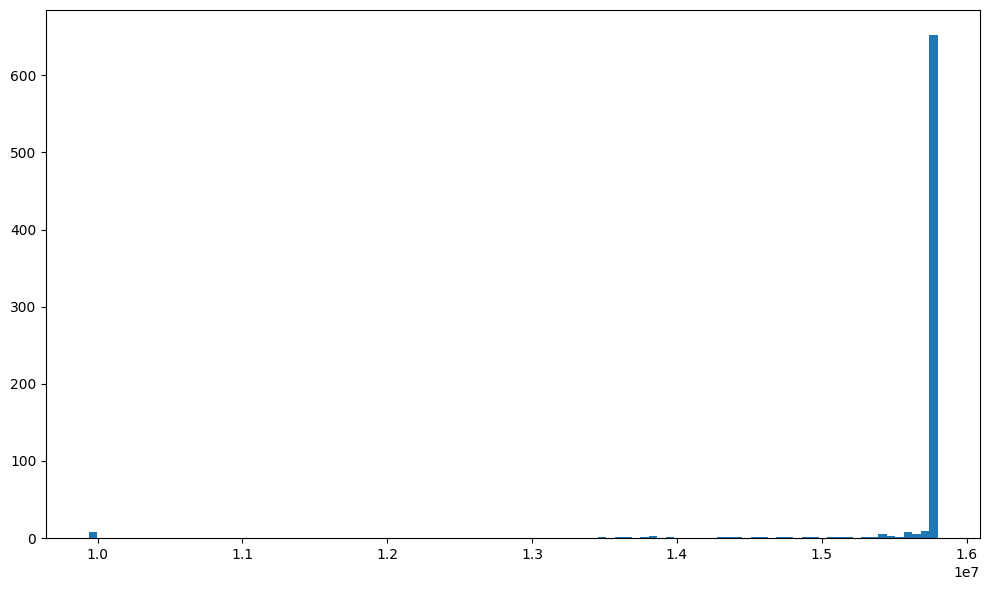

In [82]:
plt.figure(figsize=(10, 6))
plt.hist(partition_size.values(), bins=100)
plt.tight_layout()
plt.show()

## Plot scores

In [83]:
same_partition_scores = []
diff_partition_scores = []
for cix1, cix2, score in cluster_similarity_scores:
    if cix1 == cix2:
        continue
    pix1s = cluster_partitions[cix1]
    pix2s = cluster_partitions[cix2]
    if (len(pix1s) == 1 and pix1s[0] in pix2s) or (len(pix2s) == 1 and pix2s[0] in pix1s):
        same_partition_scores.append(score)
    else:
        diff_partition_scores.append(score)
print(len(same_partition_scores))
print(len(diff_partition_scores))

240992
1097113


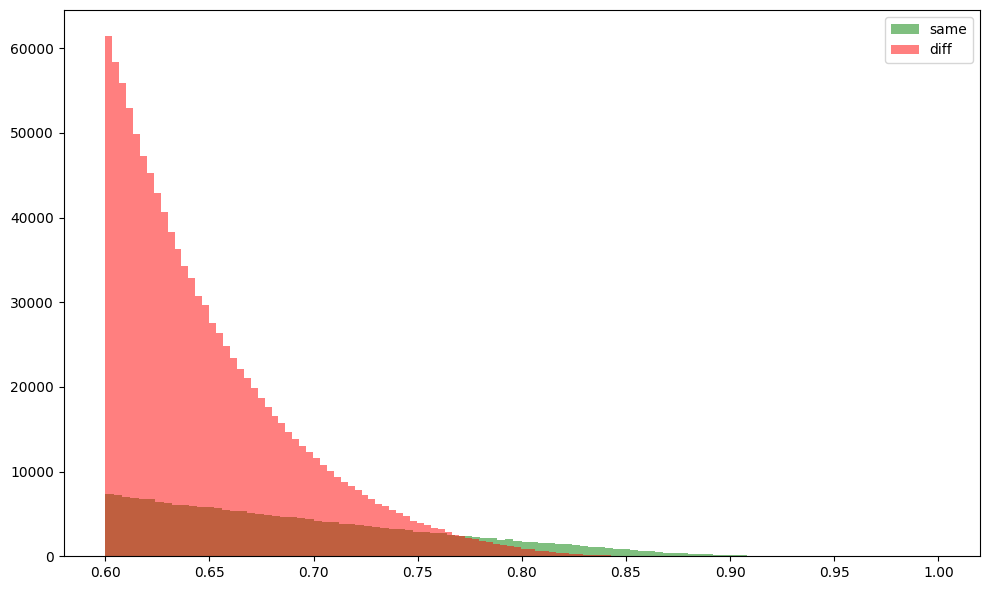

In [84]:
plt.figure(figsize=(10, 6))
plt.hist(same_partition_scores, bins=100, alpha=0.5, label="same", color='green')
plt.hist(diff_partition_scores, bins=100, alpha=0.5, label="diff", color='red')
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

## Save phonebook

In [85]:
final_partition_start = 0
cluster_final_partition = defaultdict(list)
partition2final_partition = {}
# renumber partition ids to start at 0
for cix, partitions in cluster_partitions.items():
    cluster_id = cluster_labels[cix]
    for partition in partitions:
        if partition in partition2final_partition:
            final_partition = partition2final_partition[partition]
        else:
            final_partition = final_partition_start
            partition2final_partition[partition] = final_partition_start
            final_partition_start += 1
        cluster_final_partition[cluster_id].append(final_partition)

In [86]:
# should be 720
final_partition_start

720

In [87]:
with open(phonebook_path, 'w') as f:
    json.dump(cluster_final_partition, f);

In [88]:
phonebook_path

'../data/processed/hr-phonebook.json'

In [93]:
cluster_final_partition['a']

[38]